1 - Utilizando os dados criados por vcs faça
1.1 - Criar um pipeline com um pré-processamento e classificador a sua escolha
1.2 - Inicie fazendo um holdout (treino, teste)
2 - Para seleção do modelo
2.1 - Faça um gridsearch para achar os melhores hyperparâmetros do método
2.2 - Esse gridsearch deve usar validação cruzada do tipo leave-one-out
2.3 - Selecione o modelo com melhor combinação de hyperparâmetros possíveis
3 - Para avaliação do modelo 
3.1 - Calcule acurácia, matriz de confusão, erro do tipo 1, erro do tipo 2, e calcule intervalo de confiança4 - Verifique a existência de overfitting e underfitting, justifique (olhar e analisar taxas de acerto do treino, teste, bias e variância). A argumentação de ter ou não overfitting e underfitting deve ser feita com comentários no código.

In [ ]:
pip install mlxtend --upgrade --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.metrics import zero_one_loss
from scipy.stats import t
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import plot_tree
import scipy.stats as stats
import math
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dados&colunas.csv')

df = pd.DataFrame(df,columns=['Height[m]','Weight[Kg]','HDI','Population[Mi]','Region'])
print(df)

#Setting 'eastern' as 0 and 'western' as 1
d = {'eastern': 0,'western': 1}
df['Region'] = df['Region'].map(d)

X = df.iloc[:,:4].values #features
y = df['Region'].values #class



    Height[m]  Weight[Kg]    HDI  Population[Mi]   Region
0        1.62        56.0  0.632          164.68  eastern
1        1.65        65.0  0.645         1380.00  eastern
2        1.66        59.0  0.733           25.77  eastern
3        1.68        71.5  0.810           32.36  eastern
4        1.68        74.7  0.737            3.27  eastern
5        1.70        72.8  0.938            5.85  eastern
6        1.71        61.0  0.919          126.47  eastern
7        1.72        77.7  0.761         1411.78  eastern
8        1.74        69.0  0.916           51.26  eastern
9        1.74        74.4  0.949            7.49  eastern
10       1.74        66.0  0.557          220.89  eastern
11       1.75        77.3  0.783           83.99  eastern
12       1.76        73.0  0.824          145.93  eastern
13       1.77        85.0  0.944           25.49  eastern
14       1.77        88.9  0.931            4.82  eastern
15       1.79        82.0  0.947           83.78  western
16       1.67 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=0, stratify=y)

In [123]:
pipe = Pipeline([('scaler', StandardScaler()), ('tree', tree.DecisionTreeClassifier())]) #creating pipeline

loo = LeaveOneOut()
parameters = {'tree__max_features':['auto','sqrt','log2'],'tree__min_samples_split':[2,3,4], 'tree__max_depth':[1,2,3,4,5,6,7], 'tree__min_samples_leaf':[10,9,8,7,6,5,4,3]} #different parameters
grid = GridSearchCV(pipe, param_grid=parameters, cv=loo) #creating grid and testing with params
grid.fit(X_train, y_train) #fitting train set

clf = grid.best_estimator_ #clf is a Pipeline object

print("Best Estimator:")
print(clf)
clf_score = grid.best_score_
print("Accuracy:")
print("%.2f"%(clf_score*100)+"%")

Best Estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('tree',
                 DecisionTreeClassifier(max_depth=6, max_features='log2',
                                        min_samples_leaf=6,
                                        min_samples_split=3))])
Accuracy:
89.47%


[Text(0.5, 0.75, 'X[3] <= 58.265\ngini = 0.499\nsamples = 19\nvalue = [9, 10]'),
 Text(0.25, 0.25, 'gini = 0.444\nsamples = 9\nvalue = [6, 3]'),
 Text(0.75, 0.25, 'gini = 0.42\nsamples = 10\nvalue = [3, 7]')]

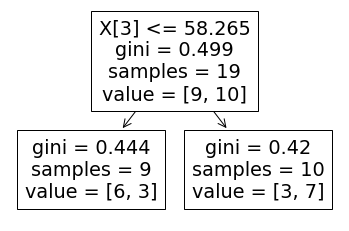

In [124]:
clf = tree.DecisionTreeClassifier(max_depth=6, max_features='log2',
                                        min_samples_leaf=6,
                                        min_samples_split=3); #tree with best params
clf = clf.fit(X_train, y_train);
tree.plot_tree(clf)

In [ ]:
print("Confusion Matrix:")
y_test_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))

Confusion Matrix:
[[4 2]
 [1 4]]


In [ ]:
print("Zero One Loss:\n%d"%zero_one_loss(y_test, y_test_pred, normalize=False))

Zero One Loss:
3


In [ ]:
print("Type 1 Error:")

print("\nType 2 Error:")

Type 1 Error:

Type 2 Error:


In [ ]:
m = y_test_pred.mean() 
s = y_test_pred.std() 
dof = len(y_test_pred)-1 
confidence = 0.95
t_crit = np.abs(t.ppf((1-confidence)/2,dof))
print("Confidence Interval:\n%.2f"%(m-s*t_crit/np.sqrt(len(y_test_pred)))+"- %.2f"%(m+s*t_crit/np.sqrt(len(y_test_pred))))

Confidence Interval:
0.21- 0.88


In [ ]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf, X_train, y_train, X_test, y_test, loss='mse', num_rounds=30,random_seed=1)

#Loss = Bias + Variance
print('Avarage expected loss: %.3f' %avg_expected_loss)
print('Avarage bias^2: %.3f' %avg_bias)
print('Avarage variance: %.3f' %avg_var)

print("Bias/Variance: %.3f"%(avg_bias/avg_var))

#Julgando pelo clf, é possível ver que o melhor classificador encontrado tem um "max_depth=1"
#ou seja, a árvore se expande muito pouco suas folhas de classificação,
#o que caracteriza um Underfitting, isso pode se dar ao fato de que a base de dados tem um número
#pequeno de amostras

Avarage expected loss: 0.418
Avarage bias^2: 0.239
Avarage variance: 0.179
Bias/Variance: 1.331
